# TODO

- улучшить парсер (убрать пустые тексты)
- убрать наны из текстов!!!!
- передвинуть CV после метрик


## Метрики
+ + длина текста
+ + max min tf-idf
+ 0 max и min косинусное расстояние между парами слов (соседних и не соседних, если успеем посчитать), tf-idf взвешенное (умножать каждое слово на tf-idf этого слова для этого документа),
____________
+ вытащить пять самых частотных слов из текста (слово с самым высоким tf-idf - классификация с помощью правил в зависимости от пересечения самых значимых слов для группы со словами в данном документе)
+ средний вектор текста сравнить со средними по каждой группе (взять центроид текста и сравнить с центроидом группы)
+ то же самое, только по пяти частотным словам

## Модели
+ логистическая регрессия
+ случайный лес (выкинуть матрицы текстов)
+ [xgboost](https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn)
+ классификация до и после понижения размерности фичей (только все инты) с помощью Principal Composition Analysis

! делать конфьюжен матрикс

sns.heatmap(data=confusion_matrix(twenty_test.target, predicted), annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib
%matplotlib inline
import random
import warnings

df = pd.read_csv('data.csv', index_col='id')
df.head()

,text,group
id,,
0,"Любезные братцы и сестрички, «Под Корень» зако...",podkoren
1,"Завтра, в воскресение, в сообществе появится п...",podkoren
2,За время существования нашего сообщества была ...,podkoren
3,"Жизнь продолжается и, как всегда, продолжается...",podkoren
4,На днях погиб наш автор и любимый братец Тимоф...,podkoren


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df.describe(include=[np.object])

,text,group
count,2447,3000
unique,2429,5
top,Доброе утро!,kudah
freq,5,600


In [4]:
import nltk
import re
from pymystem3 import Mystem

nltk.download('punkt')
mystem_analyzer = Mystem()

lemmatized = []
unlemmatized = []

for doc in df['text']:
    text = re.sub("<br>", "", str(doc))
    word_list = nltk.word_tokenize(text)
    unlemmatized.append(word_list)
    lemmatized.append([mystem_analyzer.lemmatize(word)[0] for word in word_list])

[nltk_data] Downloading package punkt to /home/valeria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
from itertools import chain

count_unlem = 0

for el in unlemmatized:
    count_unlem += len(el)

cont_lemmatized = list(chain.from_iterable(lemmatized))

print("Количество токенов в датасете:", count_unlem)
print("Количество уникальных лемм:", len(set(cont_lemmatized)))

Количество токенов в датасете: 692543
Количество уникальных лемм: 37248


In [6]:
words_per_doc = np.mean([len(text) for text in unlemmatized])
symbols_per_doc = np.mean([len(str(doc)) for doc in df["text"]])

print("Среднее количество слов на документ:", int(words_per_doc))
print("Среднее количество символов на документ:", int(symbols_per_doc))

Среднее количество слов на документ: 230
Среднее количество символов на документ: 1281


In [7]:
from nltk.corpus import stopwords
import pymorphy2 as pm2

pmm = pm2.MorphAnalyzer()
russian_stopwords = stopwords.words("russian")

# сюда добавить парсинг получше
def parse(text):
    text = re.sub(r'[^\w\s]','', str(text))
    text = re.sub("[0-9A-Za-z#_=]", "", text)
    text = [pmm.normal_forms(x)[0] for x in text.split() if x not in russian_stopwords]
    if text == [np.nan]:
        return(['nan'])
    return text

df['text'] = df['text'].apply(parse)

In [8]:
df.head(5)

,text,group
id,,
0,"[любезный, братец, сестричка, под, корень, зак...",podkoren
1,"[завтра, воскресение, сообщество, появиться, п...",podkoren
2,"[за, время, существование, наш, сообщество, со...",podkoren
3,"[жизнь, продолжаться, продолжаться, дорога, на...",podkoren
4,"[на, день, погибнуть, наш, автор, любимый, бра...",podkoren


## TF-IDF

In [9]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

dct = Dictionary()

dct.add_documents(list(df["text"]))
corpus = []
for idx, row in df.iterrows():
    corpus.append(dct.doc2bow(row['text']))
tf_idf = TfidfModel(corpus)

In [10]:
vectors = [tf_idf[doc] for doc in corpus]

In [11]:
vectors = [{dct[el[0]]: el[1] for el in vector} for vector in vectors]
vectors[0]

{'антропология': 0.13193552536887726,
 'большой': 0.05344479063789524,
 'братец': 0.15032721936852053,
 'вдохнуть': 0.1552589573836702,
 'весь': 0.09518281651471602,
 'вечность': 0.12109074706973376,
 'воскликнуть': 0.12866292143201075,
 'вряд': 0.0921973472432415,
 'вывод': 0.08963642679724876,
 'выполнить': 0.09274880429267256,
 'выпустить': 0.10163798396933127,
 'глубоко': 0.09776731505494081,
 'говориться': 0.08528866133929136,
 'грань': 0.11552077925803443,
 'должный': 0.047119136143471956,
 'дорогой': 0.07444388304014787,
 'ещё': 0.03700306878934491,
 'закончиться': 0.09923202700494284,
 'знать': 0.042512466224095914,
 'и': 0.030564587722126505,
 'иметь': 0.15479264270676557,
 'исследование': 0.09574388920952373,
 'история': 0.05175899247409029,
 'итог': 0.15131470121113363,
 'конец': 0.05233391859077387,
 'корень': 0.16205688399197954,
 'который': 0.057524361579211584,
 'кто': 0.05415846801491459,
 'культурный': 0.08451657979140888,
 'литература': 0.07831455195453832,
 'любезный

хуй
хуй
хуй
хуй
хуй
хуй
хуй
хуй
хуй
хуй
хуй
хуй
хуй
хуй


## Embeddings

In [88]:
!wget "http://corpus.leeds.ac.uk/tools/ru/ruwac-parsed.out.xz"

--2019-06-06 23:14:42--  http://corpus.leeds.ac.uk/tools/ru/ruwac-parsed.out.xz
Распознаётся corpus.leeds.ac.uk (corpus.leeds.ac.uk)… 129.11.80.147
Подключение к corpus.leeds.ac.uk (corpus.leeds.ac.uk)|129.11.80.147|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 9768295304 (9,1G) [application/x-xz]
Сохранение в: «ruwac-parsed.out.xz.1»

ruwac-parsed.out.xz   0%[                    ]   6,39M  1,41MB/s    ост 2h 8m  ^C


In [12]:
import lzma
import os
from collections import Counter
from datetime import datetime
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LsiModel
from progressbar import progressbar
from sklearn import svm
from sklearn.exceptions import UndefinedMetricWarning
from sklearn import metrics 
from sklearn.model_selection import LeaveOneOut, cross_val_score, GridSearchCV, train_test_split
from string import punctuation as punct
from string import ascii_letters as latin
from tqdm import tqdm
punct += '»«'

corpus_archive_filename = 'ruwac-parsed.out.xz'
corpus_filename = 'corpus.txt'
premodel_filename = 'small.model'
vocabulary_filename = 'freq.txt'
model_filename = 'full.model'
sample_directory = 'sample'
manual_filename = 'manual_metrics.csv'
df_filename = 'data.csv'
lsi_model_small_filename = 'small_lsi.model'
wordlist_filename = 'wordlist.json'
idfs_filename = 'idfs.json'

In [ ]:
with lzma.open(corpus_archive_filename, mode='rt', encoding='utf-8') as f:
    with open(corpus_filename, mode='w', encoding='utf-8') as t:
        current = []
        for line_number, line in enumerate(f):
            if line_number % 10000000 == 0:
                print(line_number, datetime.now().time(), file=open('archive_log.txt', 'a', encoding='utf-8'))
            l = line.split('\t')
            if len(l) == 7:
                lemm = l[3]
                sent = l[1]
                if sent == 'SENT':
                    if set(latin).intersection(set(''.join(current))) == set():
                        current.append('\n')
                        print(' '.join(current), file=t, end='')
                    current = []
                elif lemm not in punct:
                    current.append(lemm)

In [14]:
from gensim.models import Word2Vec

sentences = list(df["text"])

In [18]:
premodel = Word2Vec(sentences, sg=1, min_count=1, workers=1, size=100)

In [20]:
list(premodel.wv.vocab.items())[0]

('любезный', <gensim.models.keyedvectors.Vocab at 0x7fc0745843c8>)

In [21]:
premodel.similarity('сестричка', 'убить')

0.92137635

In [147]:
addition = "\n"

for sent in sentences:
    addition += " ".join(sent) + '\n'
    
with open(corpus_filename, mode='a', encoding='utf-8') as t:
    t.write(addition)

In [22]:
def get_vocabulary(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            for word in line.split():
                yield word

def get_sentences(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            yield line.split()

In [23]:
from collections import Counter

word_freq = Counter(tqdm(get_vocabulary(corpus_filename)))

487263005it [04:24, 1842969.96it/s]


In [24]:
model = Word2Vec(sg=1, min_count=1, workers=1, size=100)

In [25]:
model.build_vocab_from_freq(word_freq)

In [26]:
model.train(get_sentences(corpus_filename), epochs=1, total_examples=len(word_freq))

(414160863, 487263005)

In [27]:
model.save("new_model")

In [15]:
model = Word2Vec.load('new_model')

In [16]:
list(model.wv.vocab.items())[:10]

[('это', <gensim.models.keyedvectors.Vocab at 0x7f20a5104b38>),
 ('тип', <gensim.models.keyedvectors.Vocab at 0x7f20a5104c50>),
 ('девушка', <gensim.models.keyedvectors.Vocab at 0x7f20a5104c88>),
 ('в', <gensim.models.keyedvectors.Vocab at 0x7f20a5104cc0>),
 ('один', <gensim.models.keyedvectors.Vocab at 0x7f20a5104cf8>),
 ('день', <gensim.models.keyedvectors.Vocab at 0x7f20a5104d30>),
 ('отмечать', <gensim.models.keyedvectors.Vocab at 0x7f20a5104d68>),
 ('что', <gensim.models.keyedvectors.Vocab at 0x7f20a5104da0>),
 ('на', <gensim.models.keyedvectors.Vocab at 0x7f20a5104dd8>),
 ('себя', <gensim.models.keyedvectors.Vocab at 0x7f20a5104e10>)]

In [17]:
model.similarity('сестричка', 'бля')

0.8574129

In [18]:
model.wv["антропология"]

array([ 0.39728817,  0.33759257,  0.7590469 ,  0.06518362, -0.00707845,
        0.21875107, -0.278317  , -0.12087888, -0.8043595 ,  0.21836177,
       -0.1006732 ,  0.3203989 , -0.51800084,  0.4067611 , -0.22997738,
       -0.16281371,  0.1696374 ,  0.15048559,  0.21203   , -0.24017143,
       -0.69083244,  0.49337438,  0.24594243, -0.14898317, -0.30758995,
        0.43765056, -0.15040557, -0.26634857, -0.18923329, -0.21882819,
        0.31550246, -0.10189518, -0.26420575,  0.03930803, -0.5591204 ,
        0.20390655, -0.10754047, -0.46035388,  0.3988782 ,  0.66853565,
        0.12194882,  0.20048839,  0.03152714,  0.22004724,  0.22344092,
        0.08621364,  0.08817811,  0.41683516,  0.33218208, -0.2985513 ,
       -0.06771833,  0.00605447,  0.36615172,  0.2530866 , -0.77041537,
       -0.14882922, -0.09573819, -0.05361597, -0.24468362,  0.34957165,
       -0.05098194, -0.8742342 , -0.05177836,  0.5112704 , -0.2002943 ,
       -0.19358756,  0.31097212, -0.49275833, -0.12766156, -0.07

In [19]:
df['weighted_vec'] = pd.Series(np.nan, index=df.index)
df.head()

,text,group,weighted_vec
id,,,
0,"[любезный, братец, сестричка, под, корень, зак...",podkoren,NaN
1,"[завтра, воскресение, сообщество, появиться, п...",podkoren,NaN
2,"[за, время, существование, наш, сообщество, со...",podkoren,NaN
3,"[жизнь, продолжаться, продолжаться, дорога, на...",podkoren,NaN
4,"[на, день, погибнуть, наш, автор, любимый, бра...",podkoren,NaN


In [20]:
defect_words = 0

def get_embs(word):
    global defect_words
    try:
        word_emb = model.wv[re.sub("ё", "е", str(word))]
    except KeyError:
        word_emb = np.zeros(100)
        defect_words += 1
    return word_emb

def doc_to_vec(doc, vector):
    vec = [get_embs(word) * vector[word] for word in doc]
    return vec

defect_words

0

In [21]:
d2v = [doc_to_vec(df["text"][doc], vectors[doc]) for doc in range(len(df["weighted_vec"]))]
df['weighted_vec'] = pd.Series(d2v, index=df.index)

In [22]:
df.head()

,text,group,weighted_vec
id,,,
0,"[любезный, братец, сестричка, под, корень, зак...",podkoren,"[[-0.024145605, 0.11946748, 0.261655, -0.06556..."
1,"[завтра, воскресение, сообщество, появиться, п...",podkoren,"[[-0.05039152, 0.057766065, 0.103294566, -0.01..."
2,"[за, время, существование, наш, сообщество, со...",podkoren,"[[-0.05420818, 0.03600782, 0.068977825, -0.006..."
3,"[жизнь, продолжаться, продолжаться, дорога, на...",podkoren,"[[-0.027693467, 0.072877966, 0.056998827, -0.0..."
4,"[на, день, погибнуть, наш, автор, любимый, бра...",podkoren,"[[-0.053390473, 0.04924318, 0.08710171, 0.0078..."


In [23]:
df['word_length'] = pd.Series([len(doc) for doc in df["text"]], index=df.index)
df.head()

,text,group,weighted_vec,word_length
id,,,,
0,"[любезный, братец, сестричка, под, корень, зак...",podkoren,"[[-0.024145605, 0.11946748, 0.261655, -0.06556...",107
1,"[завтра, воскресение, сообщество, появиться, п...",podkoren,"[[-0.05039152, 0.057766065, 0.103294566, -0.01...",161
2,"[за, время, существование, наш, сообщество, со...",podkoren,"[[-0.05420818, 0.03600782, 0.068977825, -0.006...",118
3,"[жизнь, продолжаться, продолжаться, дорога, на...",podkoren,"[[-0.027693467, 0.072877966, 0.056998827, -0.0...",240
4,"[на, день, погибнуть, наш, автор, любимый, бра...",podkoren,"[[-0.053390473, 0.04924318, 0.08710171, 0.0078...",233


In [24]:
def symbol_length(doc):
    length = 0
    for word in doc:
        length += len(word)
    return length

df['symbol_length'] = pd.Series([symbol_length(doc) for doc in df["text"]], index=df.index)
df.head()

,text,group,weighted_vec,word_length,symbol_length
id,,,,,
0,"[любезный, братец, сестричка, под, корень, зак...",podkoren,"[[-0.024145605, 0.11946748, 0.261655, -0.06556...",107,701
1,"[завтра, воскресение, сообщество, появиться, п...",podkoren,"[[-0.05039152, 0.057766065, 0.103294566, -0.01...",161,1062
2,"[за, время, существование, наш, сообщество, со...",podkoren,"[[-0.05420818, 0.03600782, 0.068977825, -0.006...",118,829
3,"[жизнь, продолжаться, продолжаться, дорога, на...",podkoren,"[[-0.027693467, 0.072877966, 0.056998827, -0.0...",240,1712
4,"[на, день, погибнуть, наш, автор, любимый, бра...",podkoren,"[[-0.053390473, 0.04924318, 0.08710171, 0.0078...",233,1519


In [25]:
def max_idf(vec):
    ret = -2
    for key in vec:
        if vec[key] > ret:
            ret = vec[key]
    return ret

def min_idf(vec):
    ret = 2
    for key in vec:
        if vec[key] < ret:
            ret = vec[key]
    return ret

df['max_idf'] = pd.Series([max_idf(vec) for vec in vectors], index=df.index)
df['min_idf'] = pd.Series([min_idf(vec) for vec in vectors], index=df.index)

df.head()

,text,group,weighted_vec,word_length,symbol_length,max_idf,min_idf
id,,,,,,,
0,"[любезный, братец, сестричка, под, корень, зак...",podkoren,"[[-0.024145605, 0.11946748, 0.261655, -0.06556...",107,701,0.357202,0.026378
1,"[завтра, воскресение, сообщество, появиться, п...",podkoren,"[[-0.05039152, 0.057766065, 0.103294566, -0.01...",161,1062,0.384330,0.015935
2,"[за, время, существование, наш, сообщество, со...",podkoren,"[[-0.05420818, 0.03600782, 0.068977825, -0.006...",118,829,0.220884,0.020886
3,"[жизнь, продолжаться, продолжаться, дорога, на...",podkoren,"[[-0.027693467, 0.072877966, 0.056998827, -0.0...",240,1712,0.213519,0.017622
4,"[на, день, погибнуть, наш, автор, любимый, бра...",podkoren,"[[-0.053390473, 0.04924318, 0.08710171, 0.0078...",233,1519,0.425739,0.020320


Here we will redifine cosine similarity because we are retarded

In [26]:
def cos_sim(v1, v2):
    return np.inner(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [27]:
def local_sym(vector_matrix):
    sym_list = []
    for i in range(len(vector_matrix)):
        if i != 0:
            sym_list.append(cos_sim(vector_matrix[i-1], vector_matrix[i]))
    return sym_list

def crutched_max(vec):
    if len(vec) == 0:
        return 0
    else:
        return max(vec)

def crutched_mean(vec):
    if len(vec) < 2:
        return 0
    else:
        return np.nanmean(vec)

In [28]:
df['max_loc_sym'] = pd.Series([crutched_max(local_sym(vec)) for vec in df['weighted_vec']], index=df.index)
df['mean_loc_sym'] = pd.Series([crutched_mean(local_sym(vec)) for vec in df['weighted_vec']], index=df.index)

df.head()

,text,group,weighted_vec,word_length,symbol_length,max_idf,min_idf,max_loc_sym,mean_loc_sym
id,,,,,,,,,
0,"[любезный, братец, сестричка, под, корень, зак...",podkoren,"[[-0.024145605, 0.11946748, 0.261655, -0.06556...",107,701,0.357202,0.026378,0.946426,0.841490
1,"[завтра, воскресение, сообщество, появиться, п...",podkoren,"[[-0.05039152, 0.057766065, 0.103294566, -0.01...",161,1062,0.384330,0.015935,0.946426,0.765385
2,"[за, время, существование, наш, сообщество, со...",podkoren,"[[-0.05420818, 0.03600782, 0.068977825, -0.006...",118,829,0.220884,0.020886,0.939897,0.774720
3,"[жизнь, продолжаться, продолжаться, дорога, на...",podkoren,"[[-0.027693467, 0.072877966, 0.056998827, -0.0...",240,1712,0.213519,0.017622,1.000000,0.767779
4,"[на, день, погибнуть, наш, автор, любимый, бра...",podkoren,"[[-0.053390473, 0.04924318, 0.08710171, 0.0078...",233,1519,0.425739,0.020320,0.946426,0.766841


In [29]:
source2id = {'podkoren': 0, 
             'telegony': 1,
             'kudah': 2,
             'ufo': 3, 
             'krishnaits': 4}

id2source = {v:k for k, v in source2id.items()}
df["group"] = df["group"].replace(source2id)

df.head()

,text,group,weighted_vec,word_length,symbol_length,max_idf,min_idf,max_loc_sym,mean_loc_sym
id,,,,,,,,,
0,"[любезный, братец, сестричка, под, корень, зак...",0,"[[-0.024145605, 0.11946748, 0.261655, -0.06556...",107,701,0.357202,0.026378,0.946426,0.841490
1,"[завтра, воскресение, сообщество, появиться, п...",0,"[[-0.05039152, 0.057766065, 0.103294566, -0.01...",161,1062,0.384330,0.015935,0.946426,0.765385
2,"[за, время, существование, наш, сообщество, со...",0,"[[-0.05420818, 0.03600782, 0.068977825, -0.006...",118,829,0.220884,0.020886,0.939897,0.774720
3,"[жизнь, продолжаться, продолжаться, дорога, на...",0,"[[-0.027693467, 0.072877966, 0.056998827, -0.0...",240,1712,0.213519,0.017622,1.000000,0.767779
4,"[на, день, погибнуть, наш, автор, любимый, бра...",0,"[[-0.053390473, 0.04924318, 0.08710171, 0.0078...",233,1519,0.425739,0.020320,0.946426,0.766841


In [ ]:
df.to_csv("processed_data.csv", sep='\t', encoding='utf-8')

In [42]:
df = pd.read_csv('processed_data.csv', index_col='id', sep='\t')

In [30]:
df.isnull().sum()

text             0
group            0
weighted_vec     0
word_length      0
symbol_length    0
max_idf          0
min_idf          0
max_loc_sym      4
mean_loc_sym     0
dtype: int64

In [31]:
unvec_data = df.drop(columns=['text', 'weighted_vec'])
unvec_data.head()

,group,word_length,symbol_length,max_idf,min_idf,max_loc_sym,mean_loc_sym
id,,,,,,,
0,0,107,701,0.357202,0.026378,0.946426,0.841490
1,0,161,1062,0.384330,0.015935,0.946426,0.765385
2,0,118,829,0.220884,0.020886,0.939897,0.774720
3,0,240,1712,0.213519,0.017622,1.000000,0.767779
4,0,233,1519,0.425739,0.020320,0.946426,0.766841


In [32]:
# possibly absolutely useless but I am retarded 

vec_data = df[['weighted_vec','group']]
vec_data.head()

,weighted_vec,group
id,,
0,"[[-0.024145605, 0.11946748, 0.261655, -0.06556...",0
1,"[[-0.05039152, 0.057766065, 0.103294566, -0.01...",0
2,"[[-0.05420818, 0.03600782, 0.068977825, -0.006...",0
3,"[[-0.027693467, 0.072877966, 0.056998827, -0.0...",0
4,"[[-0.053390473, 0.04924318, 0.08710171, 0.0078...",0


# Classification

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

In [39]:
unvec_data = unvec_data.fillna(0)
X = unvec_data.drop(columns=['group'])
y = unvec_data['group']
kf = KFold(n_splits=10, random_state=42, shuffle=True)
kf.get_n_splits(X)

10

In [40]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

accs = []
micro_f1s = []
micro_ps = []
micro_rs = []
macro_f1s = []
macro_ps = []
macro_rs = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
    logreg.fit(X_train, y_train)
    predicted = logreg.predict(X_test)
    accs.append(accuracy_score(predicted, y_test))
    micro_f1s.append(f1_score(predicted, y_test, average = 'micro'))
    micro_ps.append(precision_score(predicted, y_test, average = 'micro'))
    micro_rs.append(recall_score(predicted, y_test, average = 'micro'))
    macro_f1s.append(f1_score(predicted, y_test, average = 'macro'))
    macro_ps.append(precision_score(predicted, y_test, average = 'macro'))
    macro_rs.append(recall_score(predicted, y_test, average = 'macro'))

In [41]:
print("Accuracy:", np.mean(accs))
print("Micro F1:", np.mean(micro_f1s))
print("Micro prescision:", np.mean(micro_ps))
print("Micro recall:", np.mean(micro_rs))
print("Macro F1:", np.mean(macro_f1s))
print("Macro prescision:", np.mean(macro_ps))
print("Macro recall:", np.mean(macro_rs))

Accuracy: 0.4616666666666666
Micro F1: 0.4616666666666666
Micro prescision: 0.4616666666666666
Micro recall: 0.4616666666666666
Macro F1: 0.4165665712776477
Macro prescision: 0.46213516607130944
Macro recall: 0.4103538505280893


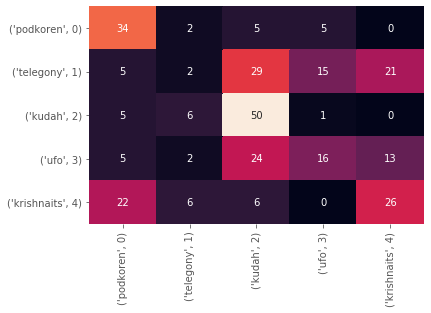

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(data=confusion_matrix(y_test, predicted), annot=True, fmt="d", cbar=False, xticklabels=source2id.items(), yticklabels=source2id.items())

In [43]:
from sklearn.ensemble import RandomForestClassifier

accs = []
micro_f1s = []
micro_ps = []
micro_rs = []
macro_f1s = []
macro_ps = []
macro_rs = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
    forest.fit(X_train, y_train)
    predicted = forest.predict(X_test)
    accs.append(accuracy_score(predicted, y_test))
    micro_f1s.append(f1_score(predicted, y_test, average = 'micro'))
    micro_ps.append(precision_score(predicted, y_test, average = 'micro'))
    micro_rs.append(recall_score(predicted, y_test, average = 'micro'))
    macro_f1s.append(f1_score(predicted, y_test, average = 'macro'))
    macro_ps.append(precision_score(predicted, y_test, average = 'macro'))
    macro_rs.append(recall_score(predicted, y_test, average = 'macro'))

In [44]:
print("Accuracy:", np.mean(accs))
print("Micro F1:", np.mean(micro_f1s))
print("Micro prescision:", np.mean(micro_ps))
print("Micro recall:", np.mean(micro_rs))
print("Macro F1:", np.mean(macro_f1s))
print("Macro prescision:", np.mean(macro_ps))
print("Macro recall:", np.mean(macro_rs))

Accuracy: 0.6086666666666667
Micro F1: 0.6086666666666667
Micro prescision: 0.6086666666666667
Micro recall: 0.6086666666666667
Macro F1: 0.5931819226493548
Macro prescision: 0.6088575095329357
Macro recall: 0.5993731724048821


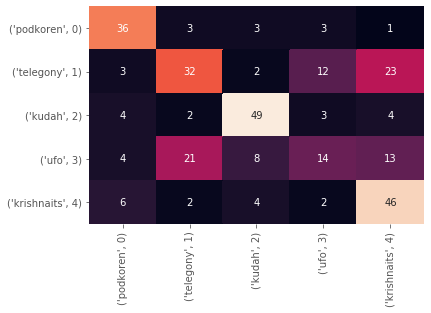

In [45]:
sns.heatmap(data=confusion_matrix(y_test, predicted), annot=True, fmt="d", cbar=False, xticklabels=source2id.items(), yticklabels=source2id.items())

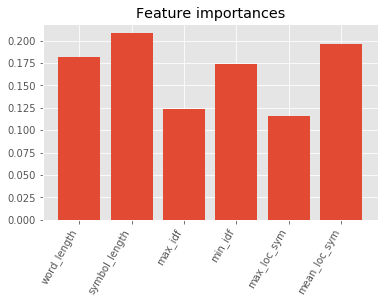

In [46]:
importances = forest.feature_importances_
fig = plt.figure()
plt.title("Feature importances")
plt.bar(X.columns, importances)
plt.xticks(X.columns)
fig.autofmt_xdate(rotation = 60)
plt.show()

In [47]:
import xgboost as xgb

accs = []
micro_f1s = []
micro_ps = []
micro_rs = []
macro_f1s = []
macro_ps = []
macro_rs = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)
    xgb_model.fit(X_train, y_train)
    predicted = xgb_model.predict(X_test)
    accs.append(accuracy_score(predicted.round(), y_test))
    micro_f1s.append(f1_score(predicted.round(), y_test, average = 'micro'))
    micro_ps.append(precision_score(predicted.round(), y_test, average = 'micro'))
    micro_rs.append(recall_score(predicted.round(), y_test, average = 'micro'))
    macro_f1s.append(f1_score(predicted.round(), y_test, average = 'macro'))
    macro_ps.append(precision_score(predicted.round(), y_test, average = 'macro'))
    macro_rs.append(recall_score(predicted.round(), y_test, average = 'macro'))

[15:22:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:22:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:22:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:22:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:22:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:22:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:22:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:22:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [48]:
print("Accuracy:", np.mean(accs))
print("Micro F1:", np.mean(micro_f1s))
print("Micro prescision:", np.mean(micro_ps))
print("Micro recall:", np.mean(micro_rs))
print("Macro F1:", np.mean(macro_f1s))
print("Macro prescision:", np.mean(macro_ps))
print("Macro recall:", np.mean(macro_rs))

Accuracy: 0.32599999999999996
Micro F1: 0.32599999999999996
Micro prescision: 0.32599999999999996
Micro recall: 0.32599999999999996
Macro F1: 0.28335120161828975
Macro prescision: 0.32693488437322815
Macro recall: 0.5006147407641173


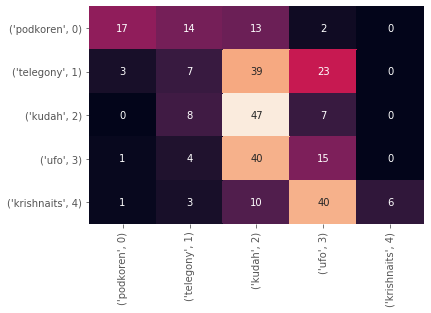

In [49]:
sns.heatmap(data=confusion_matrix(y_test, predicted.round()), annot=True, fmt="d", cbar=False, xticklabels=source2id.items(), yticklabels=source2id.items())

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

print(pca.n_components_)

accs = []
micro_f1s = []
micro_ps = []
micro_rs = []
macro_f1s = []
macro_ps = []
macro_rs = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
    forest.fit(X_train, y_train)
    predicted = forest.predict(X_test)
    accs.append(accuracy_score(predicted, y_test))
    micro_f1s.append(f1_score(predicted, y_test, average = 'micro'))
    micro_ps.append(precision_score(predicted, y_test, average = 'micro'))
    micro_rs.append(recall_score(predicted, y_test, average = 'micro'))
    macro_f1s.append(f1_score(predicted, y_test, average = 'macro'))
    macro_ps.append(precision_score(predicted, y_test, average = 'macro'))
    macro_rs.append(recall_score(predicted, y_test, average = 'macro'))

2


In [51]:
print("Accuracy:", np.mean(accs))
print("Micro F1:", np.mean(micro_f1s))
print("Micro prescision:", np.mean(micro_ps))
print("Micro recall:", np.mean(micro_rs))
print("Macro F1:", np.mean(macro_f1s))
print("Macro prescision:", np.mean(macro_ps))
print("Macro recall:", np.mean(macro_rs))

Accuracy: 0.53
Micro F1: 0.53
Micro prescision: 0.53
Micro recall: 0.53
Macro F1: 0.517307677847388
Macro prescision: 0.5305422698554892
Macro recall: 0.5251499106837473


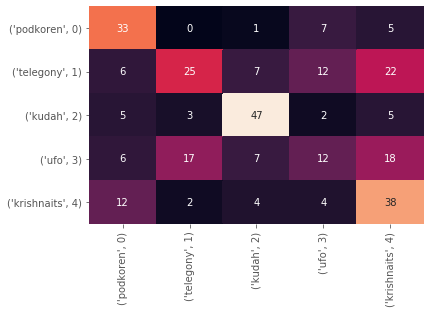

In [52]:
sns.heatmap(data=confusion_matrix(y_test, predicted.round()), annot=True, fmt="d", cbar=False, xticklabels=source2id.items(), yticklabels=source2id.items())